True vs. Estimated Factor Returns (first few rows):


,True_Factor_0,True_Factor_1,True_Factor_2,Est_Factor_0,Est_Factor_1,Est_Factor_2
2023-01,0.038024,-0.001213,-0.014168,0.037587,-0.000311,-0.014456
2023-02,-0.030274,-0.036063,-0.031683,-0.031759,-0.036606,-0.031520
2023-03,0.005343,0.010175,-0.031624,0.005897,0.008812,-0.031876
2023-04,0.017901,-0.009661,0.002936,0.017342,-0.008266,0.003936
2023-05,0.032244,0.017937,-0.005371,0.031406,0.017259,-0.005003


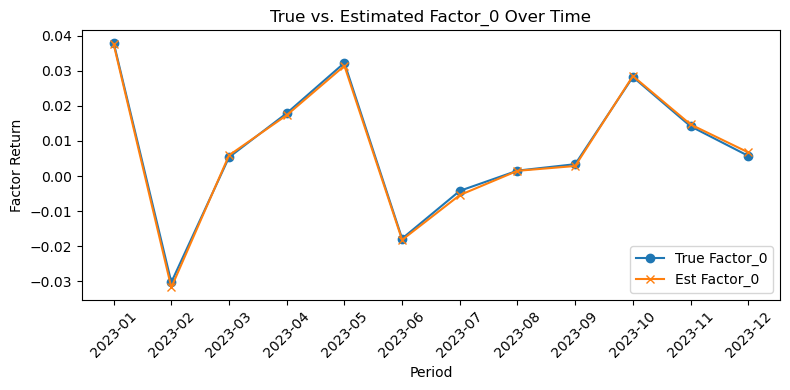

In [4]:


import warnings
warnings.filterwarnings("ignore", category=Warning)   

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt



def run_cross_sectional_regression(
    asset_returns: pd.Series,
    factor_loadings: pd.DataFrame,
    weights: pd.Series = None,
    robust: bool = True,
    huber_t: float = 1.345,
) -> pd.Series:
    """
    Run a single-month cross-sectional regression:
        r_i = sum_k x_{i,k} * f_k + u_i
    Optionally downweight outliers using Huber’s T norm.

    Parameters
    ----------
    asset_returns : pd.Series
        Monthly excess returns. Index = asset identifiers.
    factor_loadings : pd.DataFrame
        Exposures for the same month. Index = asset identifiers,
        columns = factor names (e.g. ['F0', 'F1', ...]).
    weights : pd.Series, optional
        Cross-sectional weights (e.g. 1/σ² or market-cap).
        Index = asset identifiers. If None, equal-weight = 1 for all.
    robust : bool, default=True
        If True, use statsmodels.RLM with Huber’s T to downweight outliers.
        If False, use WLS (if weights given) or OLS otherwise.
    huber_t : float, default=1.345
        Tuning constant for Huber’s T.

    Returns
    -------
    pd.Series
        Estimated factor returns ˆf_k for that month.
        Index = factor names (same as factor_loadings.columns).
    """
   
    common_assets = asset_returns.index.intersection(factor_loadings.index)
    y = asset_returns.loc[common_assets].astype(float)
    X = factor_loadings.loc[common_assets].astype(float)


    # X = sm.add_constant(X)

    if weights is None:
        w = pd.Series(1.0, index=common_assets)
    else:
        w = weights.loc[common_assets].astype(float)


    if robust:
        huber = sm.robust.norms.HuberT(t=huber_t)
        model = sm.RLM(endog=y.values, exog=X.values, M=huber, weights=w.values)
        results = model.fit()
        params = results.params
    else:
        if weights is not None:
            model = sm.WLS(endog=y.values, exog=X.values, weights=w.values)
            results = model.fit()
            params = results.params
        else:
            model = sm.OLS(endog=y.values, exog=X.values)
            results = model.fit()
            params = results.params

    
    return pd.Series(params, index=X.columns, name="factor_returns")



def run_monthly_factor_returns(
    returns_df: pd.DataFrame,
    exposures_df: pd.DataFrame,
    weights_df: pd.DataFrame = None,
    robust: bool = True,
    huber_t: float = 1.345,
) -> pd.DataFrame:
    """
    Loop over each month (column) in returns_df, run cross-sectional regression,
    and collect the estimated factor returns in a DataFrame.

    Parameters
    ----------
    returns_df : pd.DataFrame
        Asset excess returns. Shape = (n_assets, n_months).
        Index = asset identifiers; columns = period identifiers (e.g. '2023-01').
    exposures_df : pd.DataFrame
        MultiIndex DataFrame of exposures.
        Index = (period, asset); columns = factor names.
    weights_df : pd.DataFrame, optional
        MultiIndex DataFrame of cross-sectional weights (same index structure).
        If None, equal-weight is used.
    robust : bool, default=True
        If True, uses RLM (Huber’s T). If False, WLS/OLS.
    huber_t : float, default=1.345
        Tuning constant for Huber’s T.

    Returns
    -------
    pd.DataFrame
        Estimated factor returns for each month. 
        Shape = (n_months, n_factors). Index = periods; columns = factor names.
    """
    periods = returns_df.columns.tolist()
    factor_names = exposures_df.columns.tolist()
    results = pd.DataFrame(index=periods, columns=factor_names, dtype=float)

    for period in periods:
        
        r_slice = returns_df[period].dropna()

        
        try:
            e_slice = exposures_df.loc[period]
        except KeyError:
            
            e_slice = exposures_df.xs(key=period, level=0)
        
        e_slice = e_slice.reindex(index=r_slice.index).dropna(how="any")

   
        if weights_df is not None:
            try:
                w_slice = weights_df.loc[period].iloc[:, 0]
            except KeyError:
                w_slice = weights_df.xs(key=period, level=0).iloc[:, 0]
            w_slice = w_slice.reindex(index=r_slice.index).dropna()
        else:
            w_slice = None

      
        if w_slice is not None:
            common = r_slice.index.intersection(e_slice.index).intersection(w_slice.index)
            r_cs = r_slice.loc[common]
            e_cs = e_slice.loc[common]
            w_cs = w_slice.loc[common]
        else:
            common = r_slice.index.intersection(e_slice.index)
            r_cs = r_slice.loc[common]
            e_cs = e_slice.loc[common]
            w_cs = None


        facret = run_cross_sectional_regression(
            asset_returns=r_cs,
            factor_loadings=e_cs,
            weights=w_cs,
            robust=robust,
            huber_t=huber_t,
        )

   
        results.loc[period, facret.index] = facret.values

    return results



np.random.seed(42)


n_assets = 50
n_factors = 3
n_months = 12


assets = [f"Asset_{i}" for i in range(n_assets)]
factors = [f"Factor_{j}" for j in range(n_factors)]
periods = [f"2023-{str(m).zfill(2)}" for m in range(1, n_months + 1)]


idx = pd.MultiIndex.from_product([periods, assets], names=["period", "asset"])
exposures_df = pd.DataFrame(index=idx, columns=factors, dtype=float)


for period in periods:
    exposures_df.loc[period] = np.random.randn(n_assets, n_factors)


true_factor_returns = pd.DataFrame(
    np.random.randn(n_months, n_factors) * 0.02,  
    index=periods,
    columns=factors,
)


returns_data = {}
for period in periods:
    
    X_mat = exposures_df.loc[period].values  
    f_true = true_factor_returns.loc[period].values  
    noise = np.random.randn(n_assets) * 0.005  
    r_vals = X_mat.dot(f_true) + noise
    returns_data[period] = pd.Series(r_vals, index=assets)

returns_df = pd.DataFrame(returns_data)

weights_df = None


estimated_factor_returns = run_monthly_factor_returns(
    returns_df=returns_df,
    exposures_df=exposures_df,
    weights_df=weights_df,
    robust=True,
    huber_t=1.345,
)


comparison = pd.concat(
    [
        true_factor_returns.rename(columns={col: f"True_{col}" for col in true_factor_returns.columns}),
        estimated_factor_returns.rename(columns={col: f"Est_{col}" for col in estimated_factor_returns.columns}),
    ],
    axis=1,
)

print("True vs. Estimated Factor Returns (first few rows):")
display(comparison.head())


plt.figure(figsize=(8, 4))
plt.plot(periods, true_factor_returns["Factor_0"], marker="o", label="True Factor_0")
plt.plot(periods, estimated_factor_returns["Factor_0"], marker="x", label="Est Factor_0")
plt.xticks(rotation=45)
plt.xlabel("Period")
plt.ylabel("Factor Return")
plt.title("True vs. Estimated Factor_0 Over Time")
plt.legend()
plt.tight_layout()
plt.show()


